# Zillow Regression Project

## Project Overview

Ability to predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

## Project Goal

The purpose of this notebook is create a regression model that predicts home values in a tri-county area of California (Los Angeles County, Orange County, and Ventrua County)

## Executive Summay

Square footage, number of bathrooms, number of bedrooms, and property age were features used to make a model that predicts home values in California

We used 3 features to build our model Bathroom count, Bedroom Count, and Square Feet of property

## Hypothesis
1.) The larger the square footage, the higher the property value

2.) The more bedrooms a house has, the higher its property value will be

3.) The more bathrooms a house has, the higher its property value will be



In [23]:
#import stuff we will need
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from prep import remove_outlier,clean_zillow, train_validate_test, get_object_cols, get_numeric_X_cols, min_max_scale
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from explore import plot_variable_pairs, plot_pairplot, correlation_exploration, get_zillow_heatmap

#import functions from my .py files
from acquire import new_zillow, get_zillow_data

# Acquire Data

In [8]:
#acquire our Zillow data from CodeUp server by parcel id specifically those that are single unit property values.
df = new_zillow()

In [9]:
# over 38k rows and 62 columns
df

parcelid       id  airconditioningtypeid  architecturalstyletypeid  \
0      14634203  2026522                    1.0                       NaN   
1      11721753   616260                    NaN                       NaN   
2      11289917  2061546                    1.0                       NaN   
3      11637029  2554497                    1.0                       NaN   
4      11705026  1834372                    NaN                       NaN   
...         ...      ...                    ...                       ...   
38617  14453399   356752                    NaN                       NaN   
38618  12019061  2108804                    1.0                       NaN   
38619  11570288   108621                    1.0                       NaN   
38620  11128688  2001476                    1.0                       NaN   
38621  10713993   774124                    1.0                       NaN   

       basementsqft  bathroomcnt  bedroomcnt buildingclasstypeid  \
0               NaN          2.0         3.0                None   
1               NaN          2.0         3.0                None   
2               NaN          2.0         3.0                None   
3               NaN          2.0         3.0                None   
4               NaN          1.0         2.0                None   
...             ...          ...         ...                 ...   
38617           NaN          3.0         5.0                None   
38618           NaN          2.0         1.0                None   
38619           NaN          2.0         2.0                None   
38620           NaN          3.0         5.0                None   
38621           NaN          3.0         3.0                None   

       buildingqualitytypeid  calculatedbathnbr  ...  taxvaluedollarcnt  \
0                        NaN                2.0  ...           289445.0   
1                        6.0                2.0  ...           205123.0   
2                        6.0                2.0  ...           136104.0   
3                        9.0                2.0  ...           810694.0   
4                        6.0                1.0  ...            35606.0   
...                      ...                ...  ...                ...   
38617                    NaN                3.0  ...           852813.0   
38618                    9.0                2.0  ...           492395.0   
38619                    7.0                2.0  ...           600608.0   
38620                    7.0                3.0  ...          1120000.0   
38621                    8.0                3.0  ...           563463.0   

       assessmentyear  landtaxvaluedollarcnt  taxamount  taxdelinquencyflag  \
0              2016.0               213516.0    3490.16                None   
1              2016.0               163175.0    2627.48                None   
2              2016.0                27214.0    2319.90                   Y   
3              2016.0               554156.0    9407.01                   Y   
4              2016.0                23624.0     543.69                None   
...               ...                    ...        ...                 ...   
38617          2016.0               496831.0   11662.88                None   
38618          2016.0               366200.0    6023.37                None   
38619          2016.0               446625.0    7255.87                None   
38620          2016.0               728000.0   13663.03                None   
38621          2016.0               338078.0    6903.66                None   

       taxdelinquencyyear  censustractandblock     id  logerror  \
0                     NaN         6.059001e+13    625 -0.061973   
1                     NaN         6.037220e+13   1018  0.017785   
2                    15.0         6.037901e+13   1248 -0.362001   
3                    13.0         6.037701e+13   1734 -0.093399   
4                     NaN         6.037232e+13   1772 -0.146056   
...          

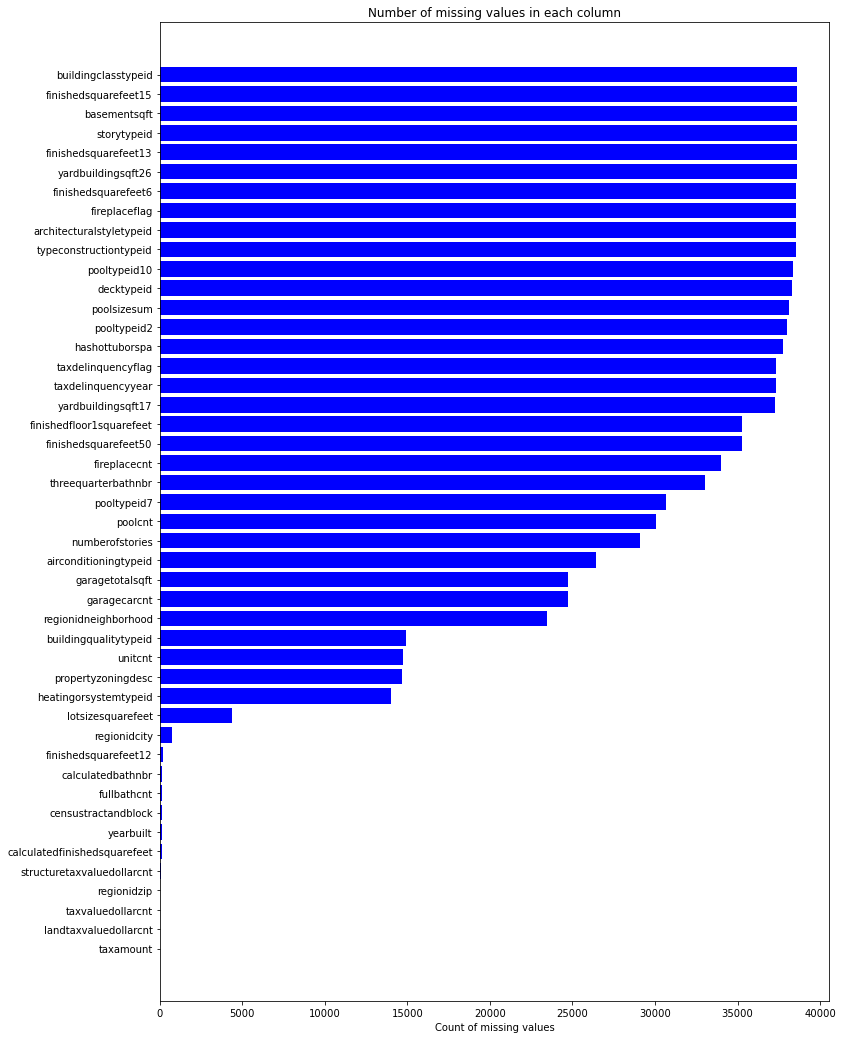

In [10]:
# visualize missing values

missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

### Takeaways:

Lots of columns and null values

Look for missing values by percentages

We won't need most of these columns

# Prepare Data

In [11]:
#clean_zillow will only select relevant columns, rename columns, drop duplicates, and drop/fill in nulls
#we now are down to 38,475 rows and 6 columns.
df = clean_zillow(df)
df.shape

(38475, 6)

In [12]:
#assuring there are no null values
df.isna().sum()

sqft         0
baths        0
beds         0
tax_value    0
fips         0
age          0
dtype: int64

In [13]:
#let's split our data using my train_validate_test function, and check our train, validate, and test shapes. Our target is tax_value.
target = 'tax_value'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)
train.shape, validate.shape, test.shape

((21546, 6), (9234, 6), (7695, 6))

In [14]:
#let's scale our data using the min_max_scale function. Not scaling the target. 
obj_cols = get_object_cols(df)
num_cols = get_numeric_X_cols(X_train, obj_cols)
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

Takeaways from Prepare

- There were a small percentage of null values that we removed
- There were a small amount of outliers that we removed by deleting any data outside 3 standard deviations


# Explore 

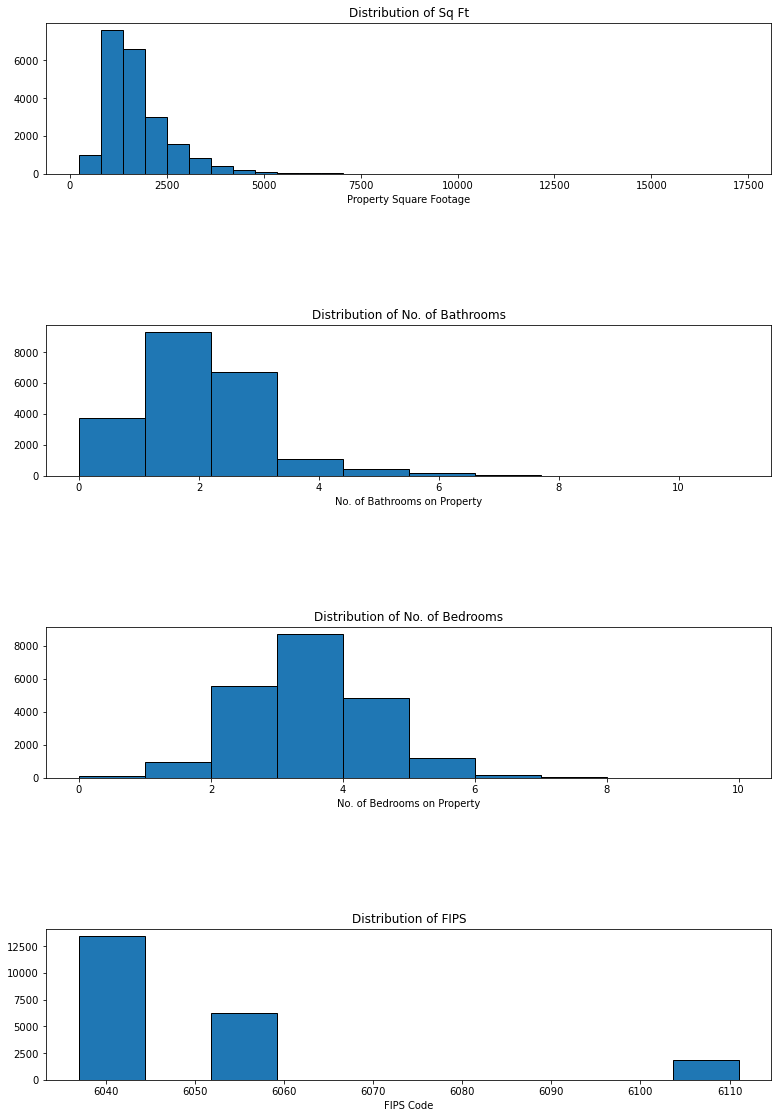

In [15]:
#checking distributions of our selected features/univariate exploration
plt.figure(figsize=(13,25))
plt.subplot(5,1,1, xlabel = 'Property Square Footage', title='Distribution of Sq Ft')
plt.hist(data=train, x='sqft', bins = 30,ec='black')

plt.subplot(5,1,2, xlabel = 'No. of Bathrooms on Property',title='Distribution of No. of Bathrooms')
plt.hist(data=train, x='baths', ec='black')

plt.subplot(5,1,3, xlabel = 'No. of Bedrooms on Property', title='Distribution of No. of Bedrooms')
plt.hist(data=train, x='beds',ec='black')

plt.subplot(5,1,4, xlabel = 'FIPS Code',title='Distribution of FIPS')
plt.hist(data=train, x='fips',ec='black')

plt.subplots_adjust(hspace=1)
plt.show()

In [16]:
#our columns of the dataframe
cols = ['sqft', 'baths','beds', 'fips','tax_value']

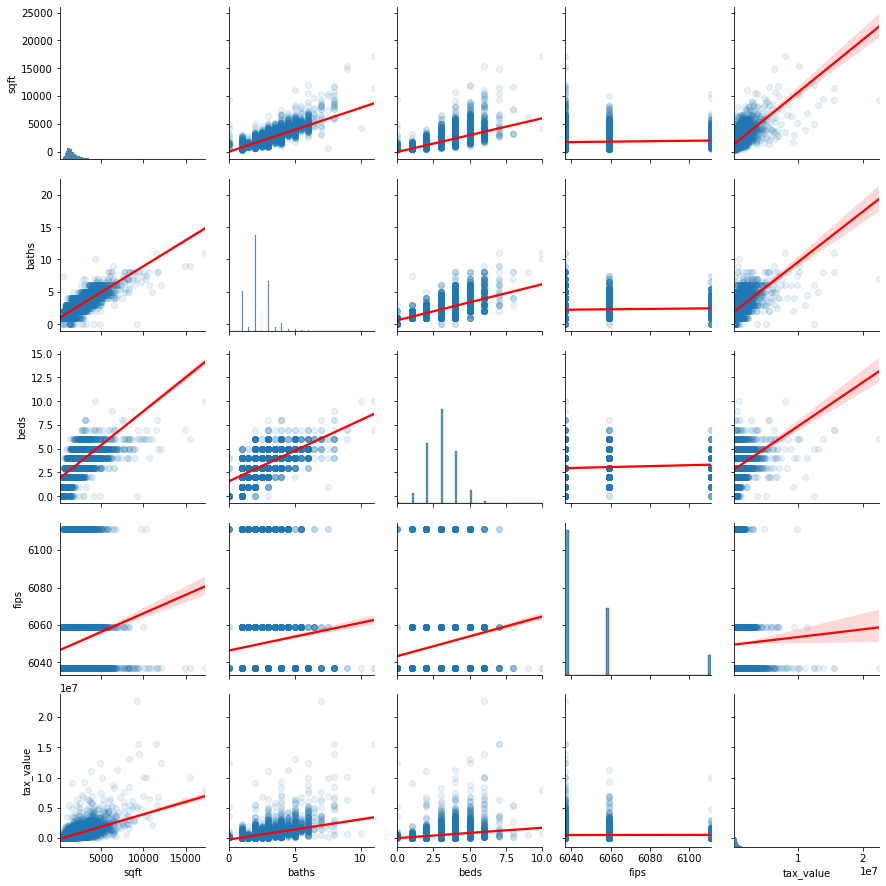

In [19]:
#pairplots 
plot_variable_pairs(train, cols)

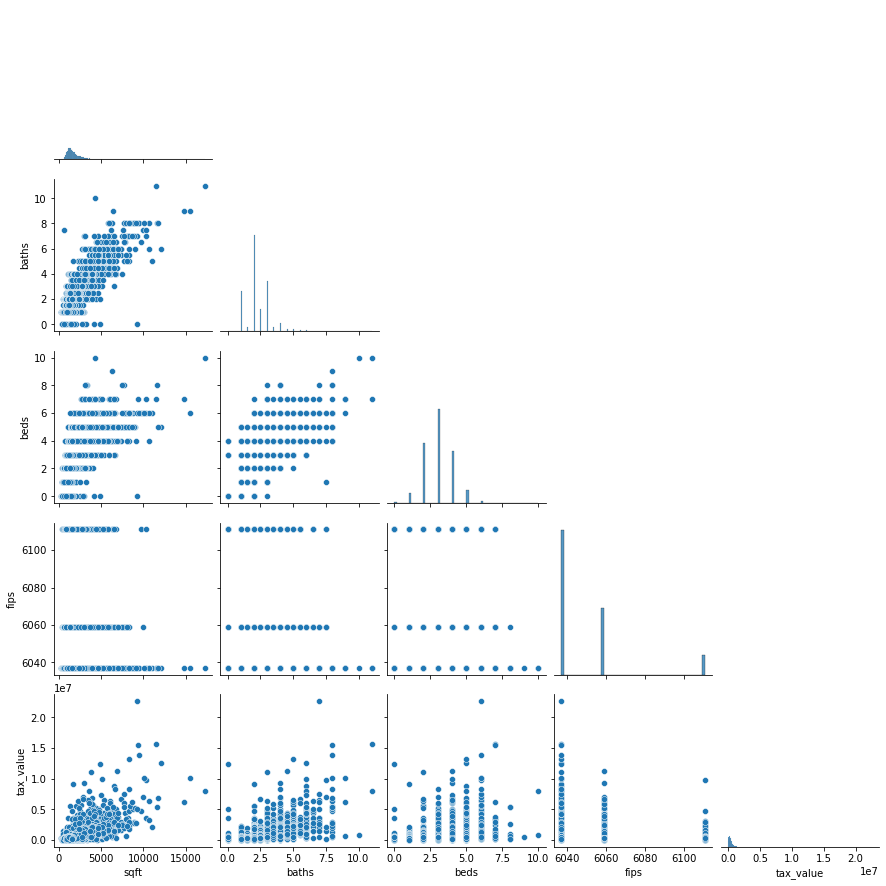

In [20]:
#scatter plots and histograms
plot_pairplot(train, cols, hue=None)

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

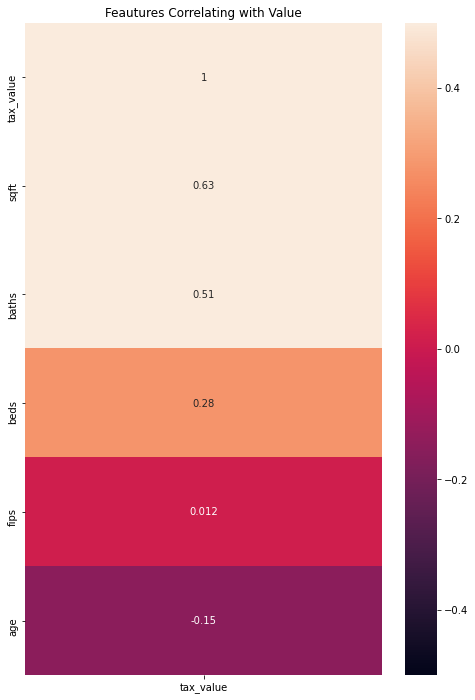

In [24]:
#heatmap with correlation of feature to tax_value
get_zillow_heatmap(train)

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.28


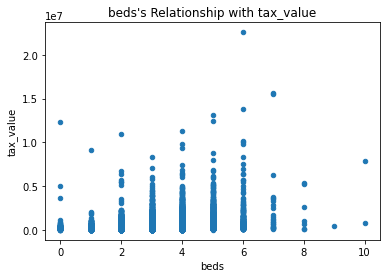

In [25]:
correlation_exploration(train, 'beds', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.51


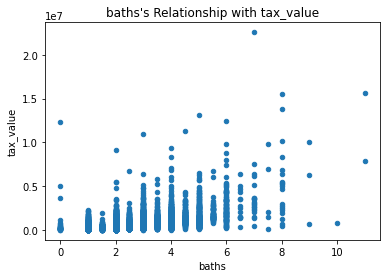

In [26]:
correlation_exploration(train, 'baths', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.63


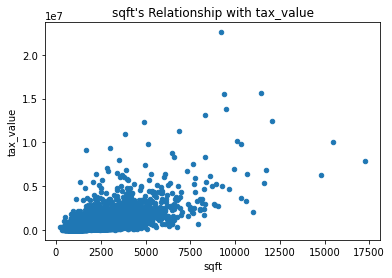

In [27]:
#sqft and tax_value
correlation_exploration(train, 'sqft', 'tax_value')

The p-value is: 0.07991013790868373. There is 0.08% chance that we see these results by chance.
r = 0.01


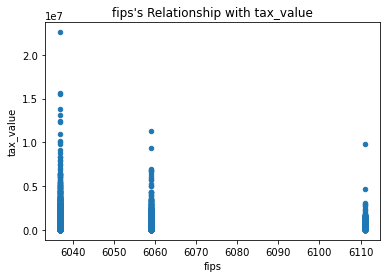

In [28]:
#FIPS and tax_value
correlation_exploration(train, 'fips', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.6


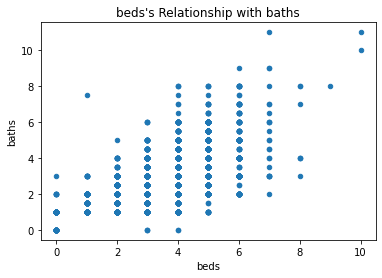

In [29]:
#Correlation between beds and baths, seems that they have a positive correlation with each other.
correlation_exploration(train, 'beds', 'baths')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.66


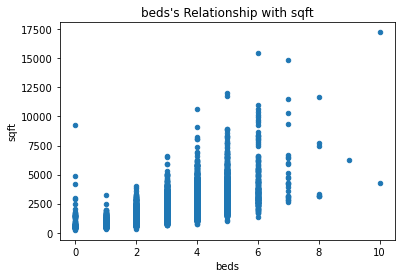

In [30]:
#Correlation between beds and sqft, seems that they have a positive correlation with each other.
correlation_exploration(train, 'beds', 'sqft')

ùêª0 : Houses > 1600 square feet are independent of their tax value price

ùêªùëé : Houses <= 1600 square feet have a significant outcome on their tax value price

In [31]:
null_hypothesis = "Houses > 1600 square feet are independent of their tax value price"
alternative_hypothesis = "Houses <= 1600 square feet have a significant outcome on their tax value price"
a = 0.05 #a for alpha 

big_house = train[train.sqft>1600]
small_house = train[train.baths<=1600]
t, p = stats.ttest_ind(big_house.tax_value, small_house.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses > 1600 square feet are independent of their tax value price
There is evidence to suggest: Houses <= 1600 square feet have a significant outcome on their tax value price
